In [154]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='whitegrid', font='CMU Serif', rc={'font.size':12, 'mathtext.fontset': 'cm', "grid.linewidth": 0.5, "axes.grid": True, "axes.grid.axis": "x"})

# Fast vs Slow

In [2]:
class Inputs():
    def __init__(self, deltaP, maxSamples, empirical=None, seed=0):
        self.deltaP = deltaP
        self.maxSamples = maxSamples
        self.empirical = empirical
        self.winning = None
        self.pA = None
        self.pB = None
        self.dP_actual = None
        self.As = []
        self.Bs = []
        self.rng = np.random.RandomState(seed=seed)
    def set_AB(self):
        self.winning = "A" if self.rng.rand()<0.5 else "B"
        highs = np.arange(0.1+self.deltaP, 0.9, 0.1)
        high = highs[self.rng.randint(len(highs))]
        low = high - self.deltaP
        nUpWin = int(high*self.maxSamples)
        nUpLose = int(low*self.maxSamples)
        self.As = np.zeros((self.maxSamples))
        self.Bs = np.zeros((self.maxSamples))
        if self.winning=="A":
            self.As[:nUpWin] = 1
            self.As[nUpWin:] = -1
            self.Bs[:nUpLose] = 1
            self.Bs[nUpLose:] = -1
            self.pA = nUpWin / self.maxSamples
            self.pB = nUpLose / self.maxSamples
        else:
            self.Bs[:nUpWin] = 1
            self.Bs[nUpWin:] = -1
            self.As[:nUpLose] = 1
            self.As[nUpLose:] = -1
            self.pB = nUpWin / self.maxSamples
            self.pA = nUpLose / self.maxSamples
        self.rng.shuffle(self.As)
        self.rng.shuffle(self.Bs)
        self.dP_actual = np.abs(self.pA - self.pB)
    def set_AB_empirical(self, trial, initialize=True):
        self.pA = self.empirical['pA'].to_numpy()[trial]
        self.pB = self.empirical['pB'].to_numpy()[trial]
        self.winning = "A" if self.pA>self.pB else "B"
        self.As = np.zeros((self.maxSamples))
        self.Bs = np.zeros((self.maxSamples))
        if initialize:  # populate the A and B arrays with the samples actually drawn in the empirical trial
            empAs = list(str(self.empirical['A'].to_numpy()[trial]))
            empAs = np.array([2*int(x)-1 for x in empAs])
            empBs = list(str(self.empirical['B'].to_numpy()[trial]))
            empBs = np.array([2*int(x)-1 for x in empBs])
            self.As[:len(empAs)] = empAs
            self.Bs[:len(empBs)] = empBs
            self.As[len(empAs):] = 2*self.rng.randint(2, size=self.maxSamples-len(empAs))-1
            self.Bs[len(empBs):] = 2*self.rng.randint(2, size=self.maxSamples-len(empBs))-1
        else:
            if self.winning=="A":
                self.As[:nUpWin] = 1
                self.As[nUpWin:] = -1
                self.Bs[:nUpLose] = 1
                self.Bs[nUpLose:] = -1
            else:
                self.Bs[:nUpWin] = 1
                self.Bs[nUpWin:] = -1
                self.As[:nUpLose] = 1
                self.As[nUpLose:] = -1
            self.rng.shuffle(self.As)
            self.rng.shuffle(self.Bs)
        self.dP_actual = np.abs(self.pA - self.pB)
    def get_AB(self, t):
        AB = [self.As[int(t)], self.Bs[int(t)]] if t<self.maxSamples else [0,0]
        AB = [AB[0], 0] if t%1.0<0.5 else [0, AB[1]]  # A presented for 500ms, then B presented for 500ms
        return AB

In [3]:
def build_network(inputs, nNeurons=1000, tau=0.1, seed=0, w_time=0, w_ramp=0.2, w_delta=0, T=0.3, S=[0,0]):
    
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03
    
    func_evidence = lambda t: inputs.get_AB(t)
    func_thr = lambda t: T
    func_start = lambda t: S if t<1 else [0,0]
    func_urgency = lambda t: -w_time * t
    func_ramp = lambda x: tau * w_ramp * x
    func_uncertainty = lambda x: -w_delta * np.abs(x[0]-x[1])
    func_greater = lambda x: [x[0]-x[1], x[1]-x[0]] 
    
    ePos = nengo.dists.Choice([[1]])
    iPos = nengo.dists.Uniform(0.01, 1)
    dInh = -1e1*np.ones((2*nNeurons, 1))

    with net:
        # Inputs
        evidence = nengo.Node(func_evidence)
        time = nengo.Node(func_urgency)
        thr = nengo.Node(func_thr)
        start = nengo.Node(func_start)
        
        # Ensembles
        value = nengo.networks.EnsembleArray(nNeurons, 2)
        accumulate = nengo.networks.EnsembleArray(nNeurons, 2)
        combined = nengo.Ensemble(2*nNeurons, 2)
        gate = nengo.Ensemble(nNeurons, 1, encoders=ePos, intercepts=iPos)
        action = nengo.networks.EnsembleArray(nNeurons, 2, encoders=ePos, intercepts=iPos)
        
        # Connections
        nengo.Connection(evidence, value.input)
        nengo.Connection(start[0], accumulate.ea_ensembles[0], synapse=tau, function=func_ramp)
        nengo.Connection(start[1], accumulate.ea_ensembles[1], synapse=tau, function=func_ramp)
        nengo.Connection(value.ea_ensembles[0], accumulate.ea_ensembles[0], synapse=tau, function=func_ramp)
        nengo.Connection(value.ea_ensembles[1], accumulate.ea_ensembles[1], synapse=tau, function=func_ramp)
        nengo.Connection(accumulate.output, accumulate.input, synapse=tau)
        nengo.Connection(accumulate.output, combined)
        nengo.Connection(combined, gate, function=func_uncertainty)
        nengo.Connection(combined, action.input, function=func_greater)
        nengo.Connection(time, gate)
        nengo.Connection(thr, gate)
        nengo.Connection(gate, action.input, transform=[[-1], [-1]])

        # Probes
        net.pEvidence = nengo.Probe(evidence)
        net.pValue = nengo.Probe(value.output)
        net.pAccumulate = nengo.Probe(accumulate.output)
        net.pGate = nengo.Probe(gate)
        net.pAction = nengo.Probe(action.output)
        
        # references
        net.w_ramp = w_ramp
        net.w_delta = w_delta
        
    return net

In [4]:
def is_correct(inputs, net, sim, dt=0.001, action_threshold=0.0):
    chooseA = np.argwhere(sim.data[net.pAction][:,0] > action_threshold)
    chooseB = np.argwhere(sim.data[net.pAction][:,1] > action_threshold)
    timeA = chooseA[0][0]*dt if len(chooseA)>0 else sim.trange()[-1]
    timeB = chooseB[0][0]*dt if len(chooseB)>0 else sim.trange()[-1]
    if inputs.winning=="A":
        if timeA == timeB:  # forced response
            correct = True if sim.data[net.pAccumulate][-1][0] > sim.data[net.pAccumulate][-1][1] else False
            time = timeA
        elif timeA < timeB:
            correct = True
            time = timeA
        elif timeB < timeA:
            correct = False
            time = timeB
    elif inputs.winning=="B":
        if timeB == timeA:  # forced response
            correct = True if sim.data[net.pAccumulate][-1][1] > sim.data[net.pAccumulate][-1][0] else False
            time = timeB
        elif timeB < timeA:
            correct = True
            time = timeB
        elif timeA < timeB:
            correct = False
            time = timeA
    return correct, int(np.ceil(2*time)), time

In [81]:
def run_trials(args, target='fast', load=False):
    if load:
        data = pd.read_pickle(f"data/{target}.pkl")
    else:
        participant_id = args['participant_id']
        empirical_data = pd.read_pickle("empirical_data.pkl").query("maxSamples==12 & delta==0.1 &participant_id==@participant_id")
        empirical_cues = empirical_data['cues'].to_numpy()
        empirical_accuracy = empirical_data['correct'].to_numpy()
        deltaP = 0.1
        maxSamples = 12
        dt = 0.001

        inputs = Inputs(deltaP=deltaP, maxSamples=maxSamples, seed=args['seed'], empirical=empirical_data)
        inputs.set_AB_empirical(0)
        net = build_network(inputs, T=args['T'], w_ramp=args['w_ramp'], w_time=args['w_time'], w_delta=args['w_delta'], seed=args['seed'])

        dfs = []
        columns = ('agent', 'trial', 'cues', 'correct')
        for trial in range(empirical_data.shape[0]):
            print(f"trial {trial}")
            inputs.set_AB_empirical(trial)
            sim = nengo.Simulator(net, progress_bar=False)
            with sim:
                sim.run(maxSamples, progress_bar=True)
            correct, cue, time = is_correct(inputs, net, sim)
            dfs.append(pd.DataFrame([['model', trial, cue, 1.0*correct,]], columns=columns))
            dfs.append(pd.DataFrame([['human', trial, empirical_cues[trial], 1.0*empirical_accuracy[trial]]], columns=columns))

        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{target}.pkl")
    return data

In [155]:
args_fast = {
    'participant_id': '58c54d6d2775404a9c3a3cde65c32a71',
    'seed':74,
    'T':0.31,
    'w_ramp':0.1,
    'w_time':0.04,
    'w_delta':0.7,
}

args_slow = {
    'participant_id': 'ece1f226b161426aafd433aa0e933b5d',
    'seed':417,
    'T':0.21,
    'w_ramp':0.12,
    'w_time':0.0,
    'w_delta':0.0,
}

fast_data = run_trials(args=args_fast, target='fast', load=True)
slow_data = run_trials(args=args_slow, target='slow', load=True)

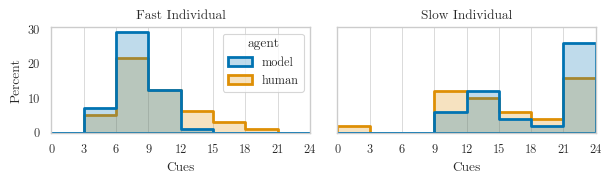

In [162]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((6.28, 2)))
sns.histplot(data=fast_data, x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[0], stat='percent', multiple='layer', element='step', linewidth=2)
sns.histplot(data=slow_data, x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[1], stat='percent', multiple='layer', element='step', linewidth=2)
axes[0].set(xlabel='Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)), title='Fast Individual')
axes[1].set(xlabel='Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)), title='Slow Individual')
axes[1].get_legend().remove()
plt.tight_layout()
fig.savefig(f"plots/fast_vs_slow.svg")
fig.savefig(f"plots/fast_vs_slow.png", dpi=600)

In [74]:
np.sum(np.abs(fast_data["sim cues"] - fast_data["emp cues"]))

137

In [75]:
np.sum(np.abs(slow_data["sim cues"] - slow_data["emp cues"]))

103

# Empirical SAT

In [140]:
emp = pd.read_pickle("data/collapsed_empirical_data.pkl")

<AxesSubplot: xlabel='mean cues', ylabel='mean correct'>

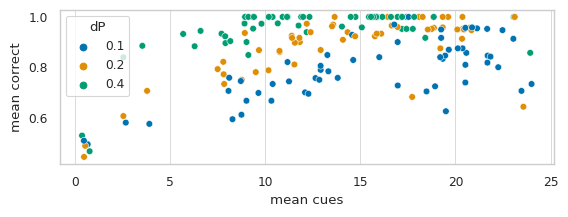

In [143]:
fig, ax = plt.subplots(figsize=((6.38, 2)))
sns.scatterplot(data=emp_collapsed, x='mean cues', y='mean correct', hue='dP', palette=palette[:3])

<AxesSubplot: xlabel='mean cues', ylabel='mean correct'>

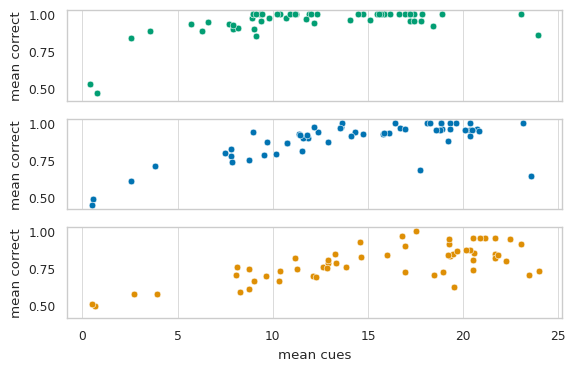

In [142]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=((6.38, 4)), sharex=True, sharey=True)
sns.scatterplot(data=emp.query("dP==0.4"), x='mean cues', y='mean correct', color=palette[2], ax=axes[0])
sns.scatterplot(data=emp.query("dP==0.2"), x='mean cues', y='mean correct', color=palette[0], ax=axes[1])
sns.scatterplot(data=emp.query("dP==0.1"), x='mean cues', y='mean correct', color=palette[1], ax=axes[2])

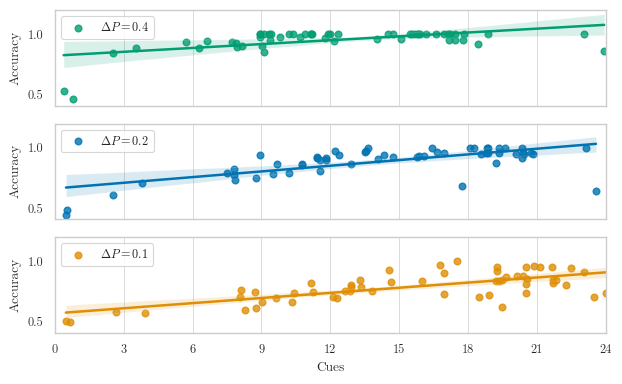

In [161]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=((6.38, 4)), sharex=True, sharey=True)
sns.regplot(data=emp.query("dP==0.4"), x='mean cues', y='mean correct', color=palette[2], ax=axes[0], label=r'$\Delta P=0.4$')
sns.regplot(data=emp.query("dP==0.2"), x='mean cues', y='mean correct', color=palette[0], ax=axes[1], label=r'$\Delta P=0.2$')
sns.regplot(data=emp.query("dP==0.1"), x='mean cues', y='mean correct', color=palette[1], ax=axes[2], label=r'$\Delta P=0.1$')
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[2].legend(loc='upper left')
axes[0].set(ylabel='Accuracy', xlabel=None)
axes[1].set(ylabel='Accuracy', xlabel=None)
axes[2].set(ylabel='Accuracy', xlabel='Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
plt.tight_layout()
fig.savefig(f"plots/SAT_empirical.svg")
fig.savefig(f"plots/SAT_empirical.png", dpi=600)

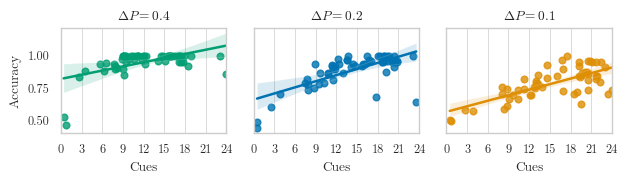

In [166]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((6.38, 2)), sharex=True, sharey=True)
sns.regplot(data=emp.query("dP==0.4"), x='mean cues', y='mean correct', color=palette[2], ax=axes[0])
sns.regplot(data=emp.query("dP==0.2"), x='mean cues', y='mean correct', color=palette[0], ax=axes[1])
sns.regplot(data=emp.query("dP==0.1"), x='mean cues', y='mean correct', color=palette[1], ax=axes[2])
axes[0].set(ylabel='Accuracy', xlabel='Cues', title=r'$\Delta P=0.4$')
axes[1].set(ylabel=None, xlabel='Cues', title=r'$\Delta P=0.2$')
axes[2].set(ylabel=None, xlabel='Cues', title=r'$\Delta P=0.1$', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
plt.tight_layout()
fig.savefig(f"plots/SAT_empirical.svg")
fig.savefig(f"plots/SAT_empirical.png", dpi=600)